In [1]:
import numpy as np
import h5py
from sklearn.decomposition import FastICA, PCA

import matplotlib as plt
%pylab inline

from PIL import Image
from torchvision import transforms

from scipy.stats import ortho_group  # Requires version 0.18 of scipy

Populating the interactive namespace from numpy and matplotlib


/home/axsys/es3773/anaconda2/envs/py27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## define network -- in this case alexnet

In [2]:
import torch
import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        
    def forward(self, x):
        x = self.features(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs):
    model = AlexNet(**kwargs)  
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [3]:

##########################################################
def plotHistogram(data, bin_start, bin_end, num_bins, title=''):
    #plot Histogram
    plt.figure(figsize=(6,3))
    plt.hist(data,bins=np.linspace(bin_start,bin_end, num_bins),color='orange',ec='white')
    plt.title(title)
    plt.show()
#########################################################

In [4]:
def permuteWeights(weights): 
    """permute the weights of a trained network -- can pass in a matrix or tensor"""
    #convert from pytorch tensor to numpy array
    weights = np.array(weights)
    #record original reshape so can reshape later
    orig_shape = np.shape(weights)
    #Flatten weights 
    flattened_weights = np.ndarray.flatten(weights)
    #Permute values 
    permuted_weights_flat =  torch.from_numpy(np.random.permutation(np.array(flattened_weights)))
    #Reshape weights 
    permuted_weights = np.reshape(permuted_weights_flat, orig_shape)
    print np.shape(permuted_weights)
    return permuted_weights
    

In [5]:
def drawWeightsFromMatchedGaussian(weights):
    """compute the mean and std of weights and draw new weights from this distribution"""
    #convert from pytorch tensor to numpy array
    weights = np.array(weights)
    #record original reshape so can reshape later
    orig_shape = np.shape(weights)
    #compute mean
    mean = np.mean(weights)
    #compute std
    std = np.std(weights)
    #draw from gaussian 
    random_weights = np.random.normal(mean, std, orig_shape)
    return random_weights
    

In [6]:
def randomWeightsMatchedDimensionality(weights): 
    """compute singular value spectrum and match this in new weights
        *** should be further sanity checked ***"""
    #Compute svd
    u,s,t = np.linalg.svd( weights) # get just the singular values
    
    num_rows = np.shape(u)[0]
    num_columns = np.shape(t)[0]
    print num_rows
    print num_columns
    i = np.eye(num_rows,num_columns)
    for ii in range(np.min([num_rows,num_columns])):
        i[ii,ii]= s[ii]
    #randomly draw new U and V  (orthonormal matrices)
    u_ = ortho_group.rvs(dim=num_rows)
    t_ = ortho_group.rvs(dim=num_columns)
    
    
    #Combine to create new matrix 
    new_weights = np.matmul(np.matmul(u_, i), t_)
    
    return new_weights

In [7]:
def setWeights(model, weights, layer_id):
    """ set the weights of a given layer (layer_id) of model to be the weights specified"""
    model.features[layer_id].weight.data =torch.from_numpy(weights).type(torch.FloatTensor)
    return model 

In [8]:
model = alexnet(pretrained=True)

In [9]:
conv_layers = [0,3,6,8,10]

## Sanity checks can be ignored ...

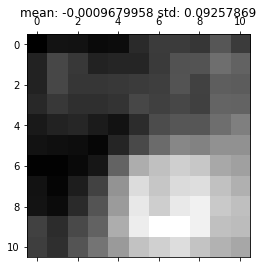

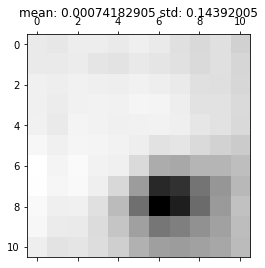

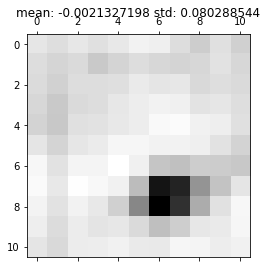

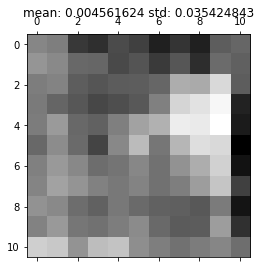

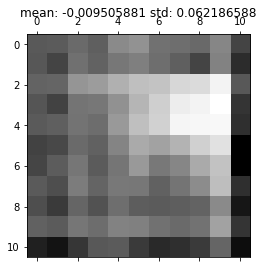

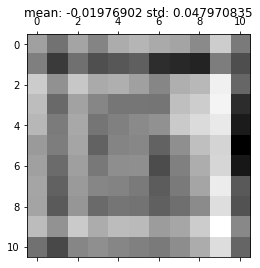

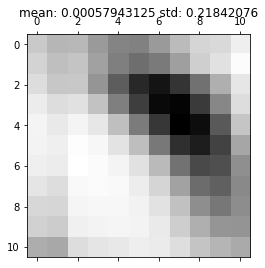

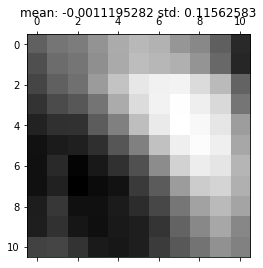

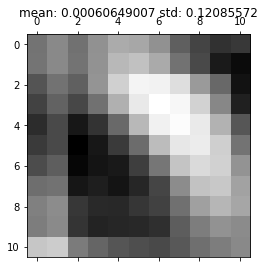

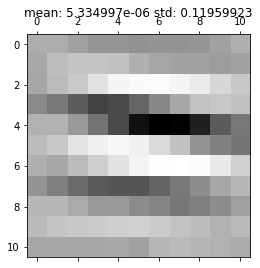

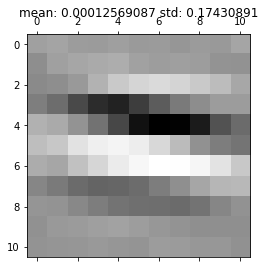

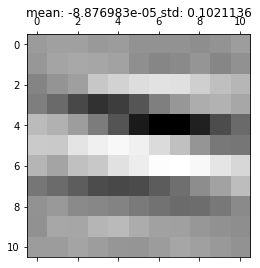

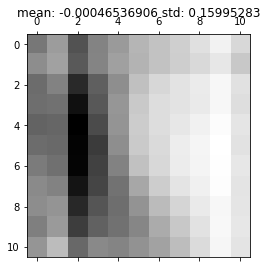

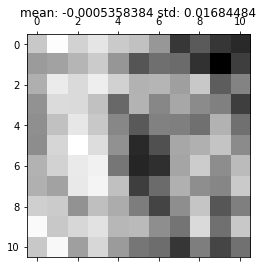

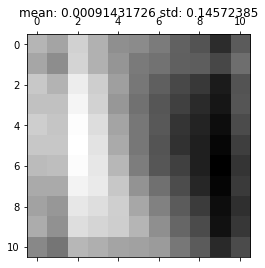

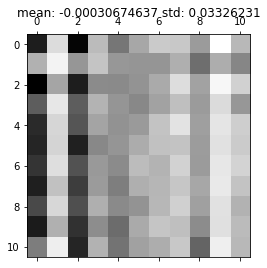

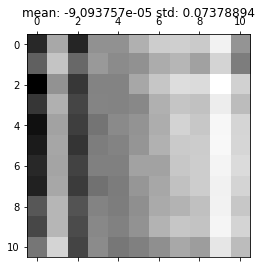

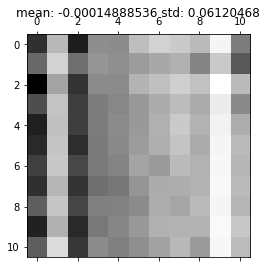

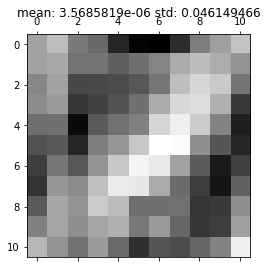

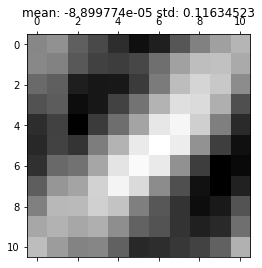

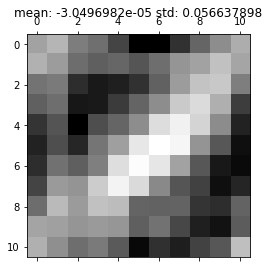

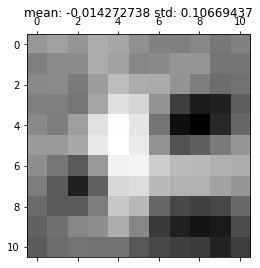

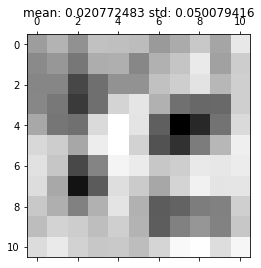

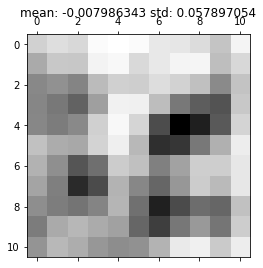

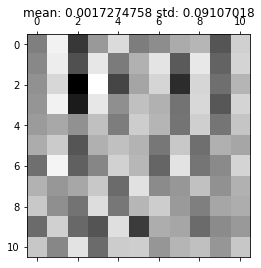

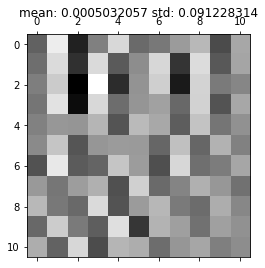

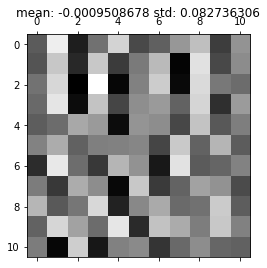

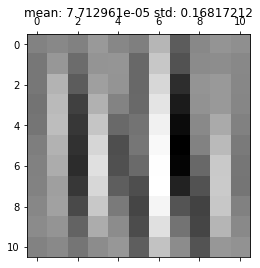

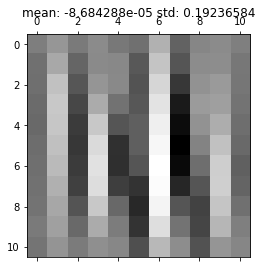

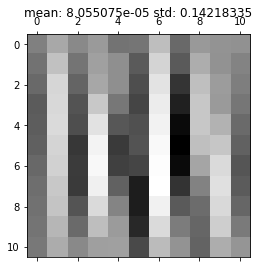

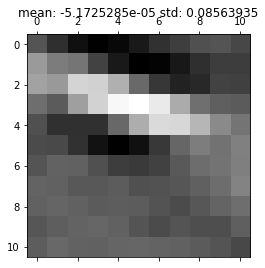

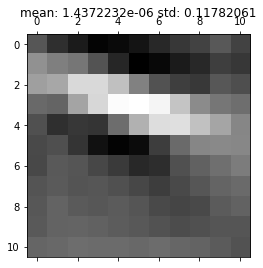

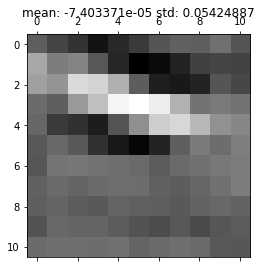

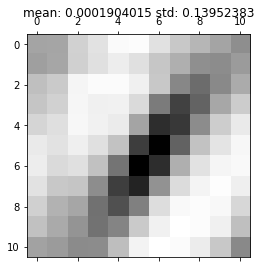

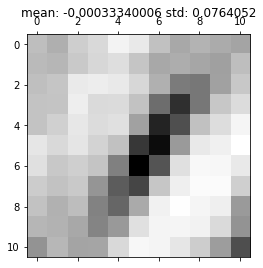

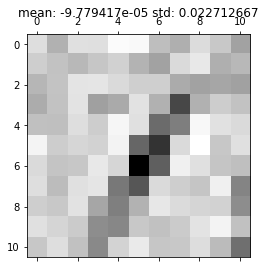

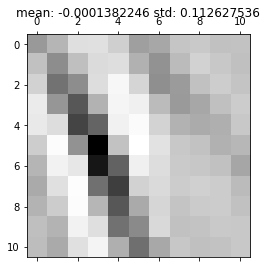

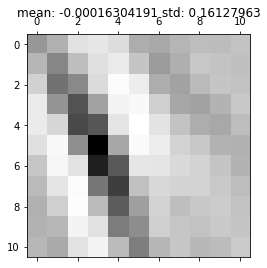

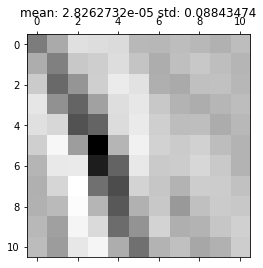

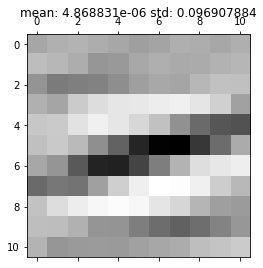

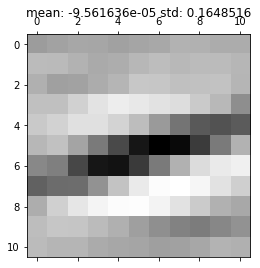

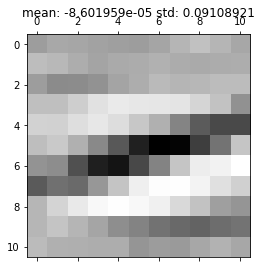

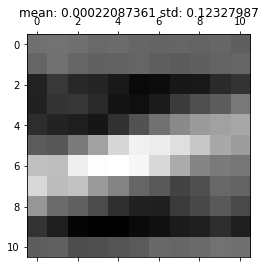

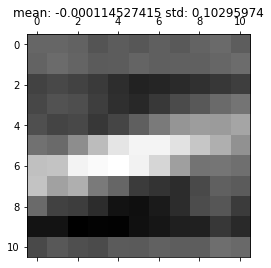

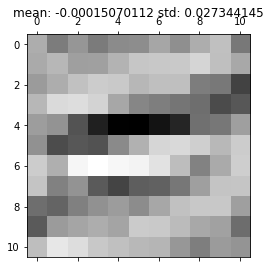

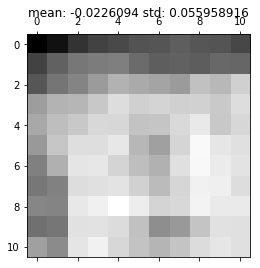

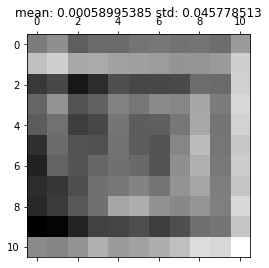

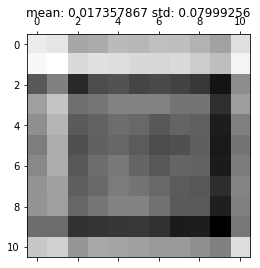

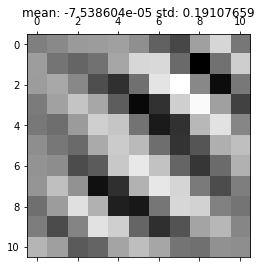

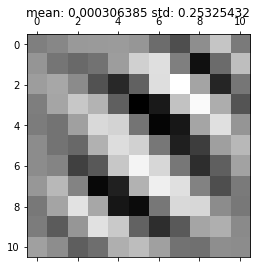

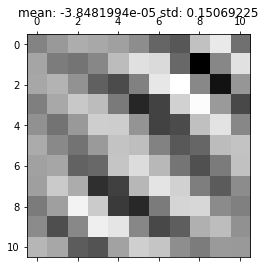

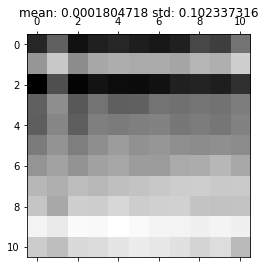

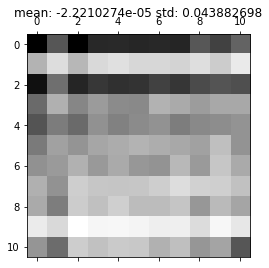

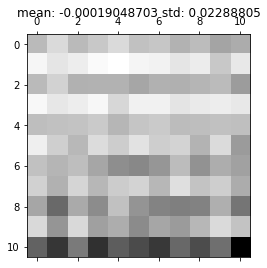

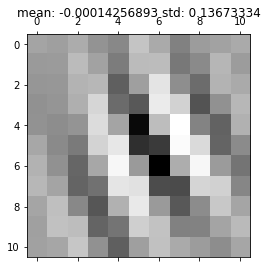

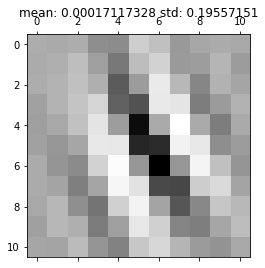

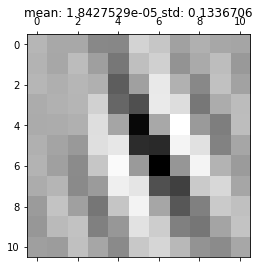

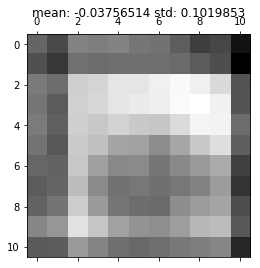

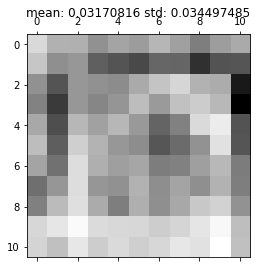

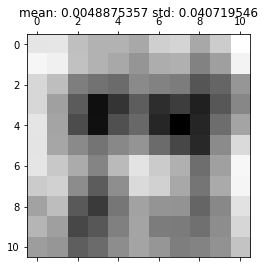

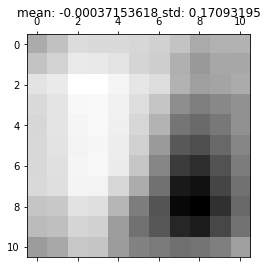

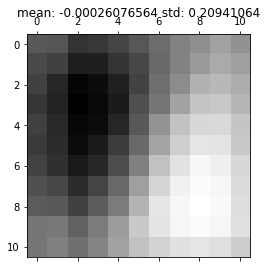

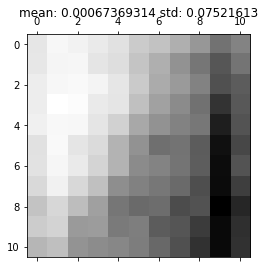

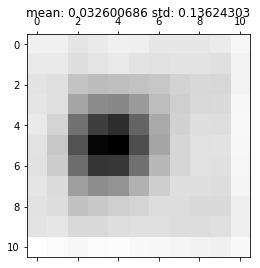

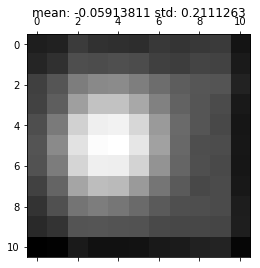

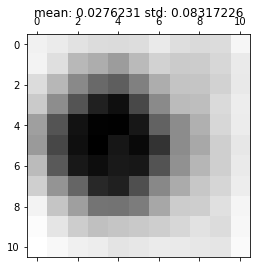

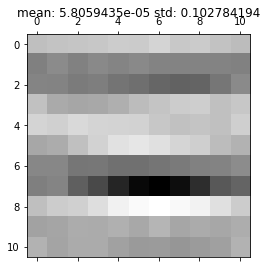

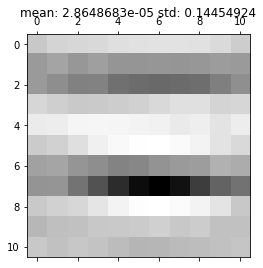

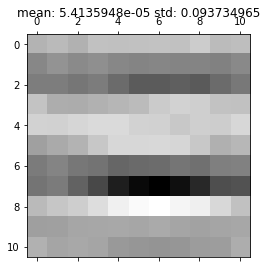

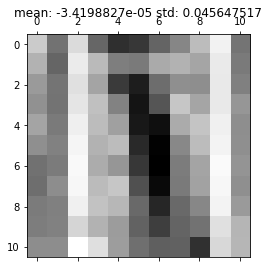

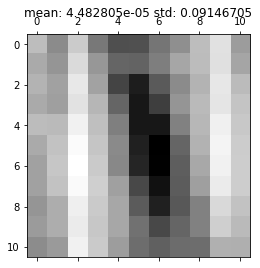

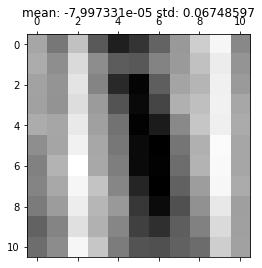

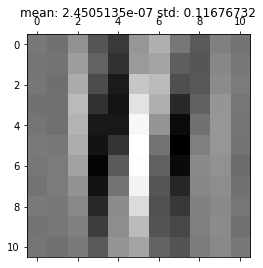

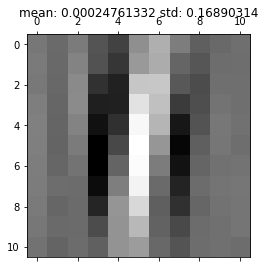

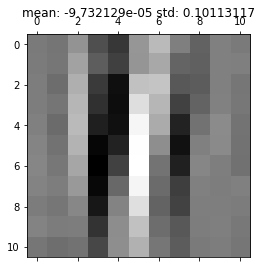

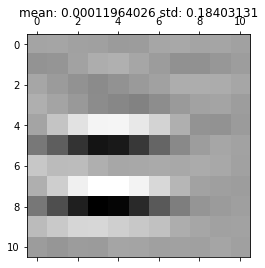

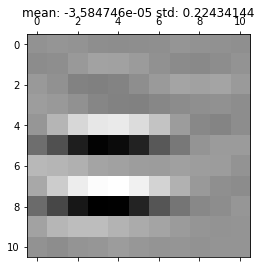

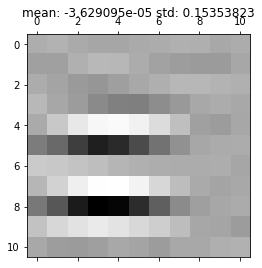

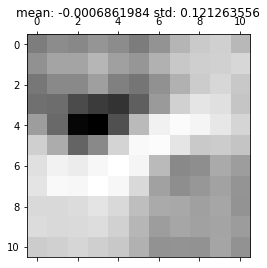

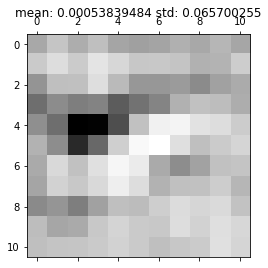

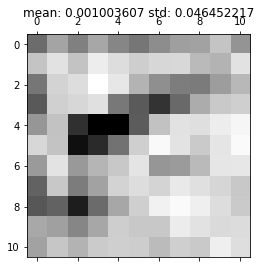

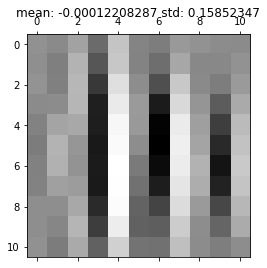

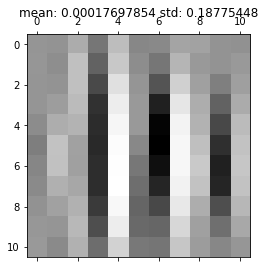

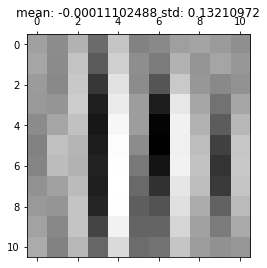

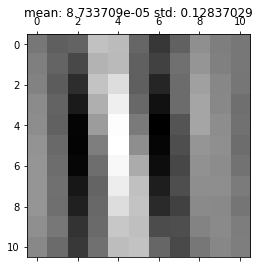

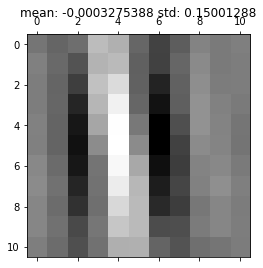

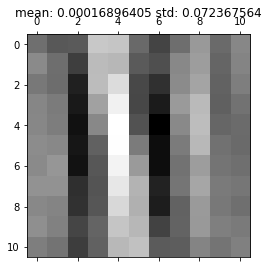

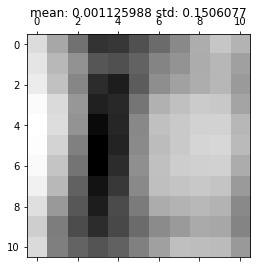

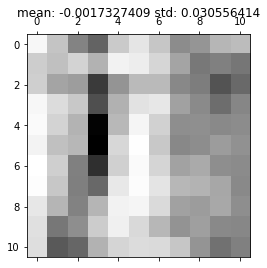

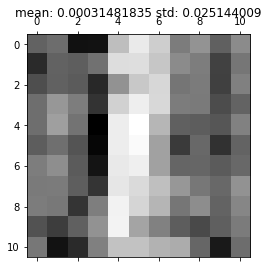

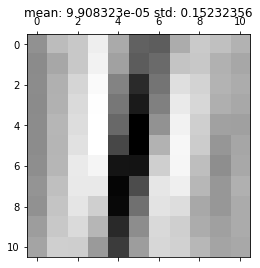

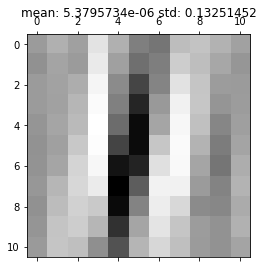

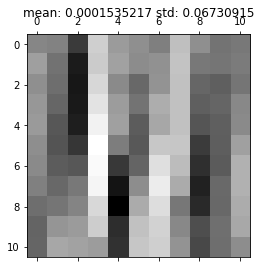

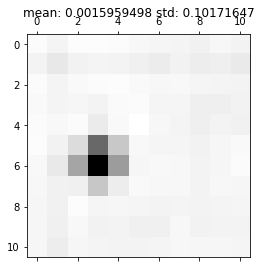

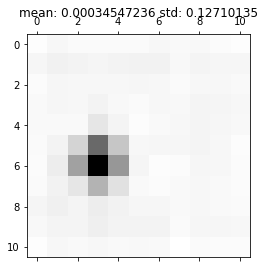

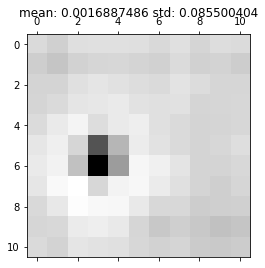

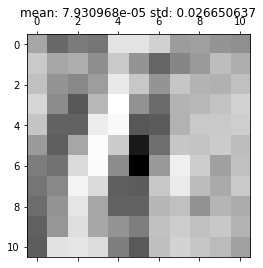

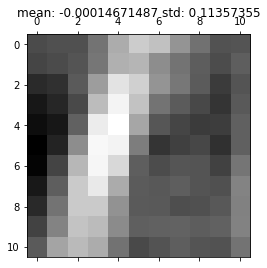

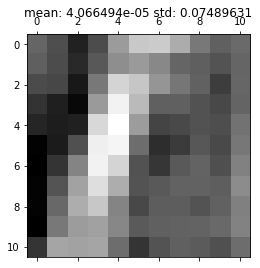

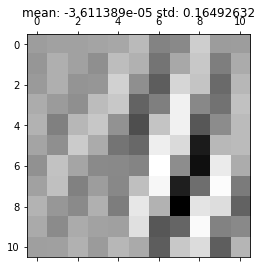

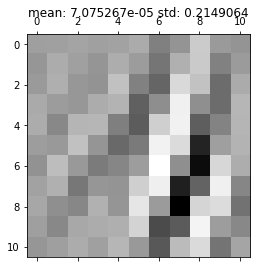

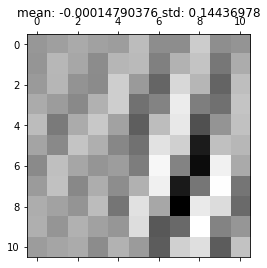

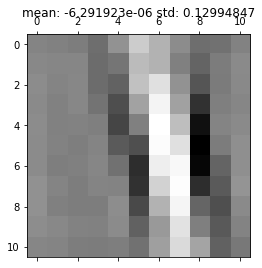

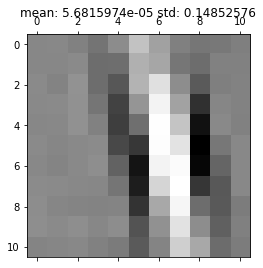

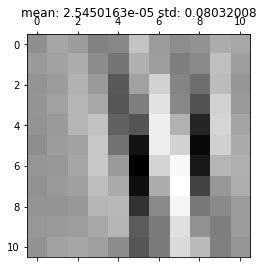

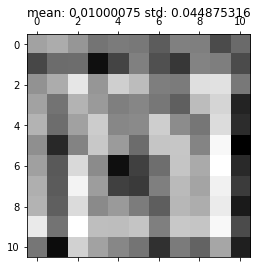

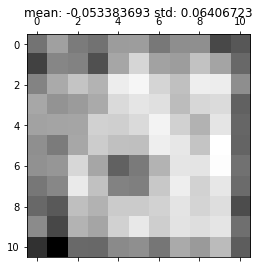

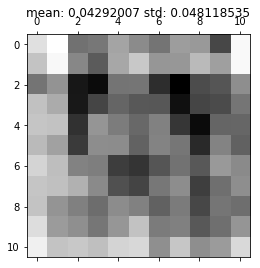

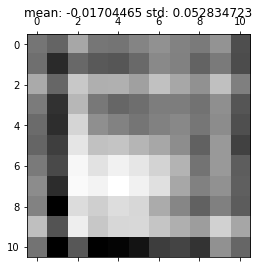

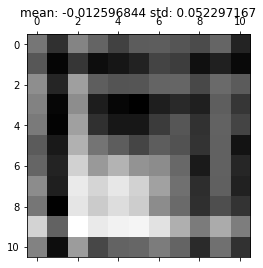

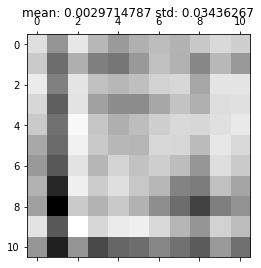

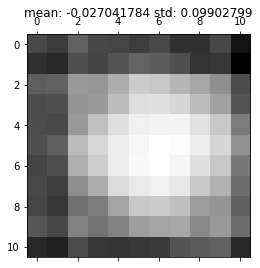

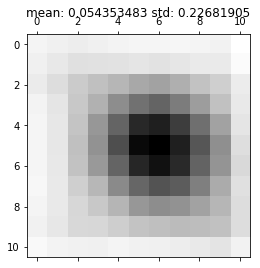

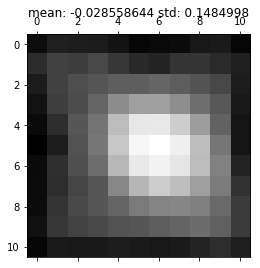

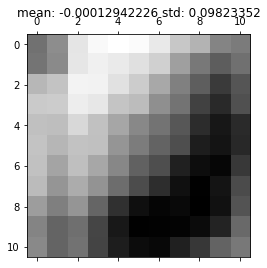

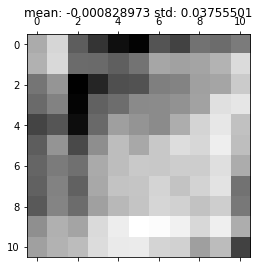

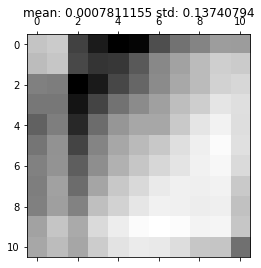

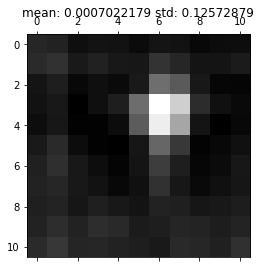

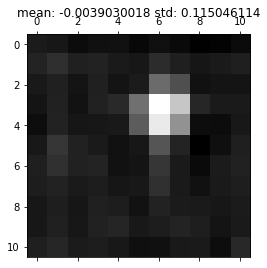

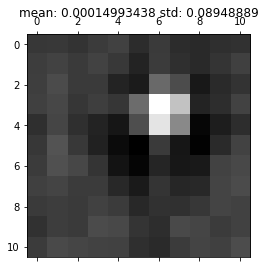

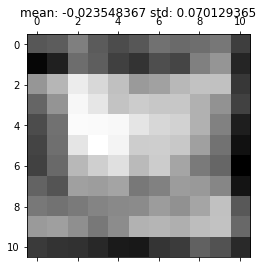

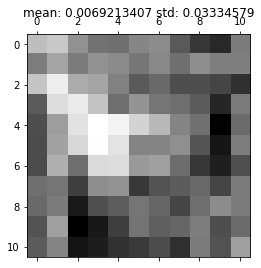

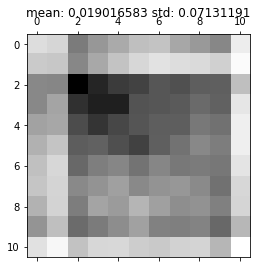

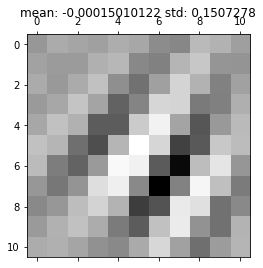

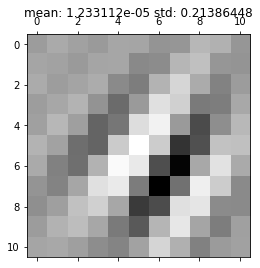

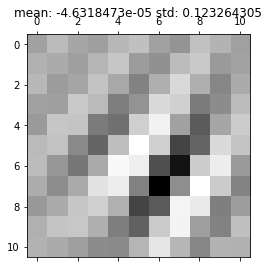

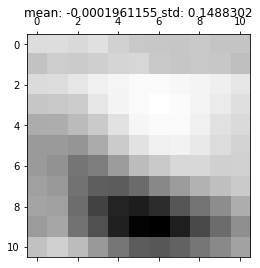

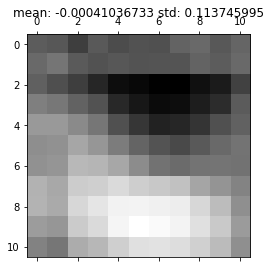

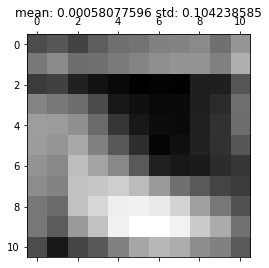

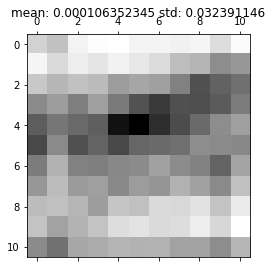

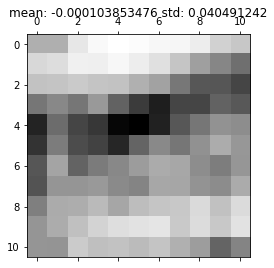

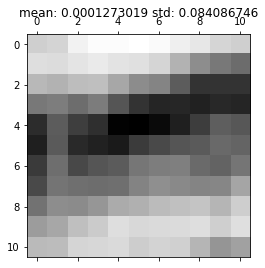

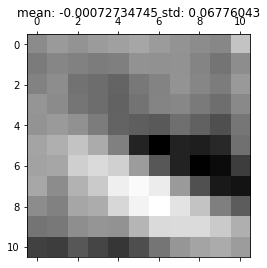

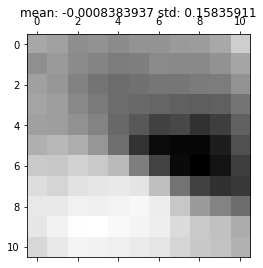

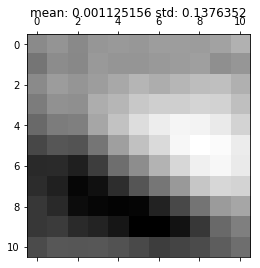

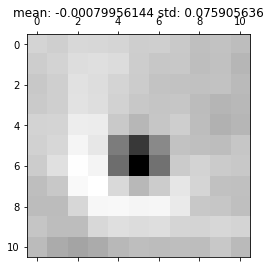

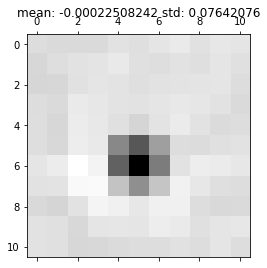

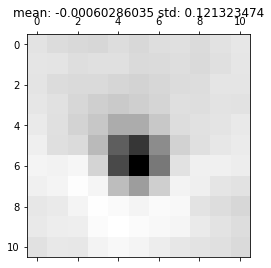

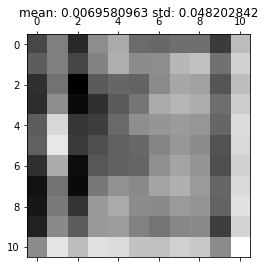

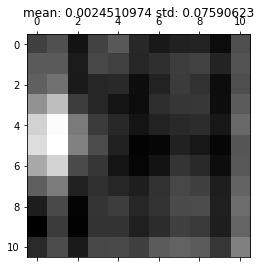

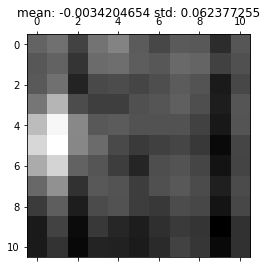

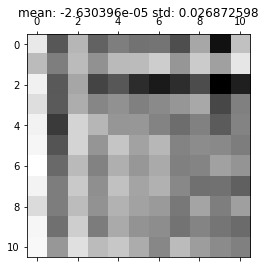

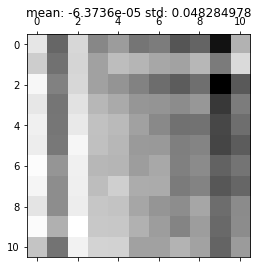

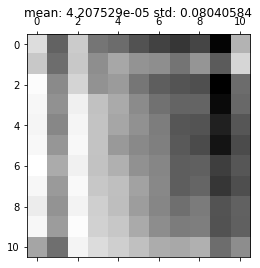

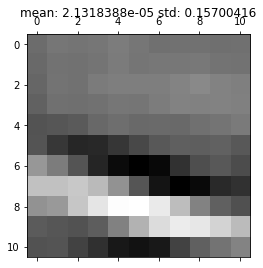

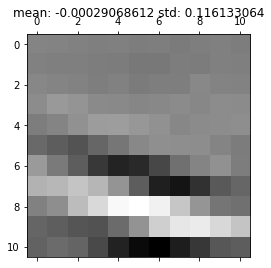

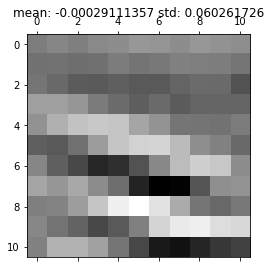

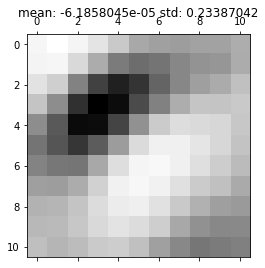

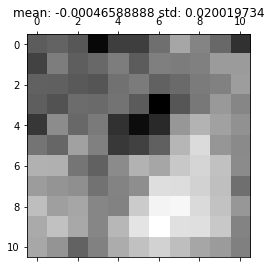

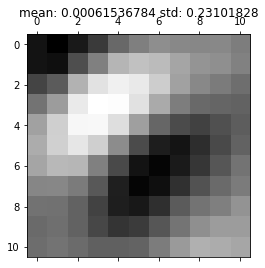

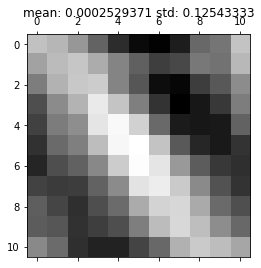

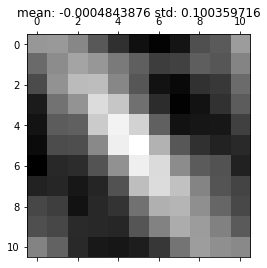

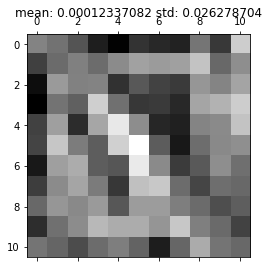

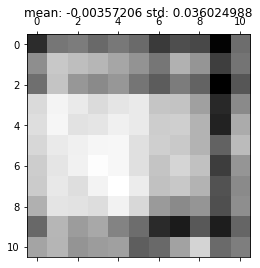

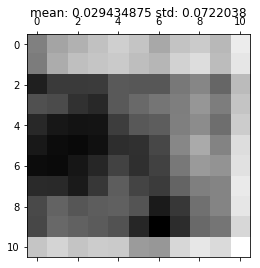

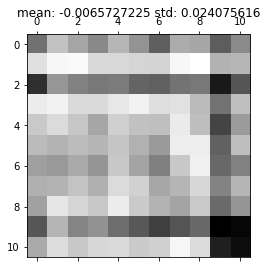

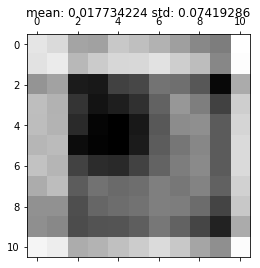

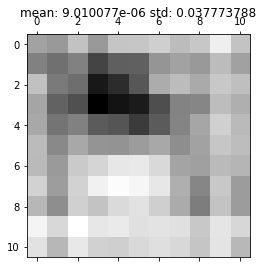

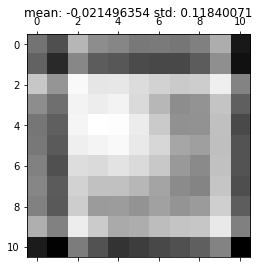

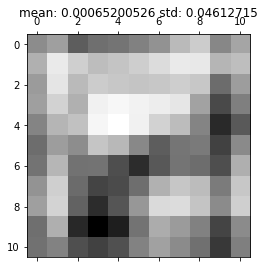

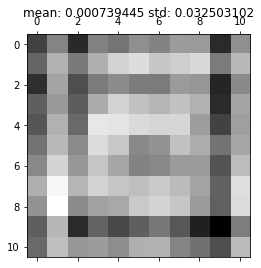

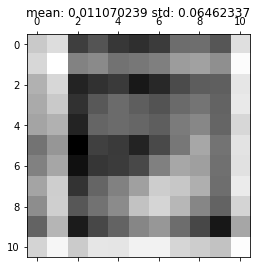

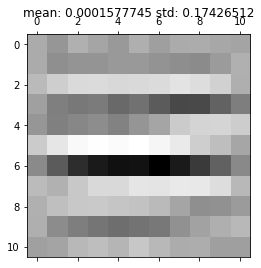

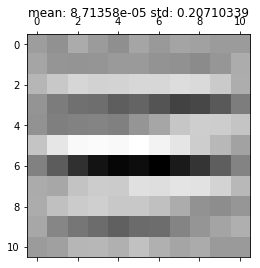

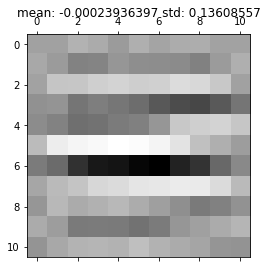

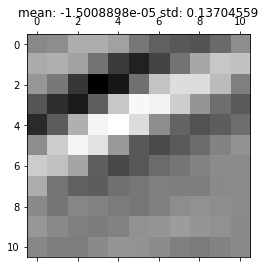

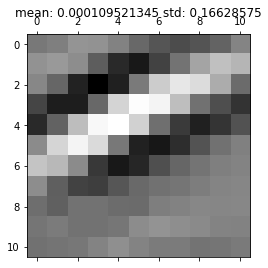

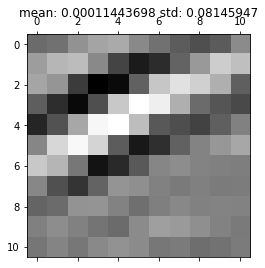

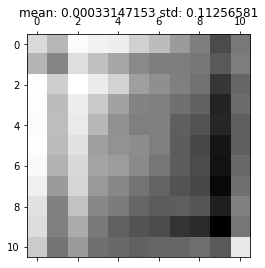

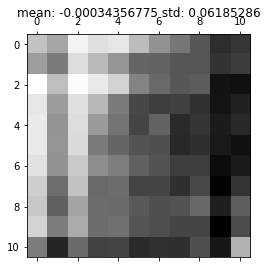

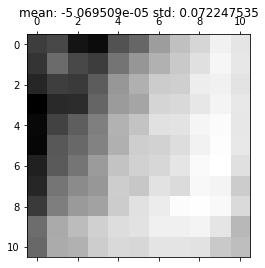

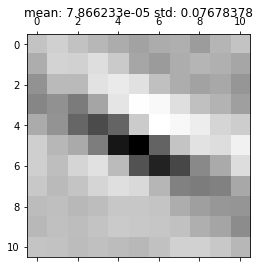

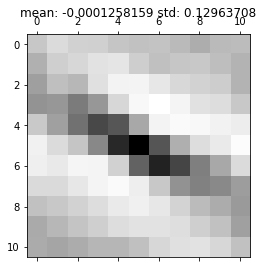

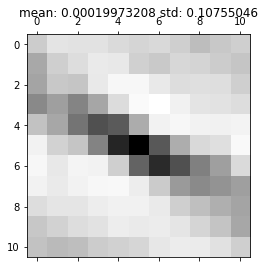

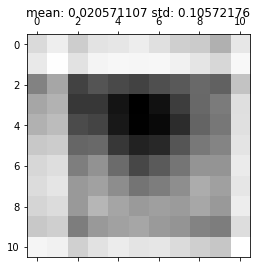

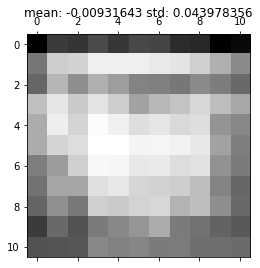

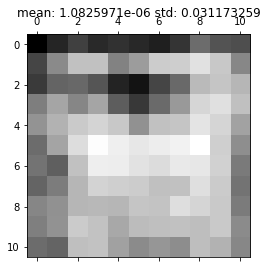

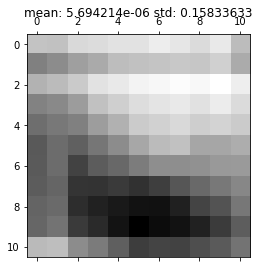

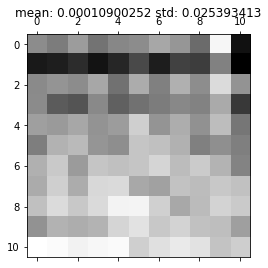

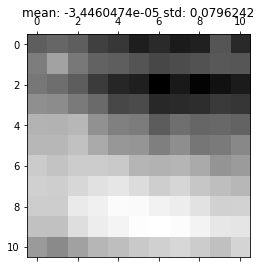

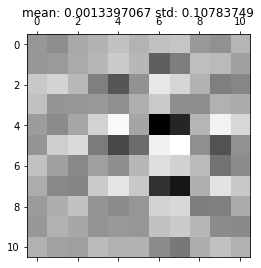

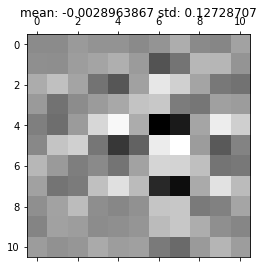

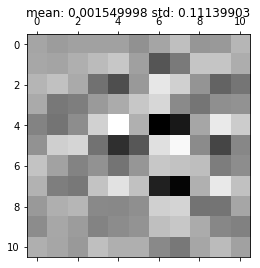

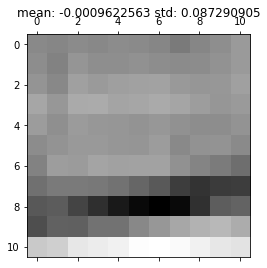

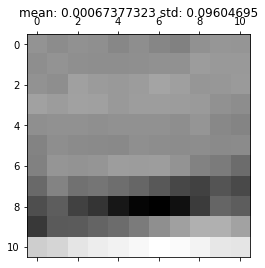

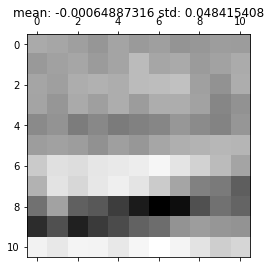

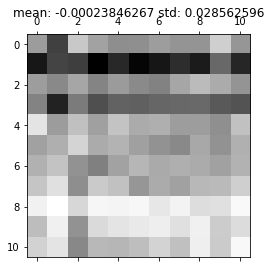

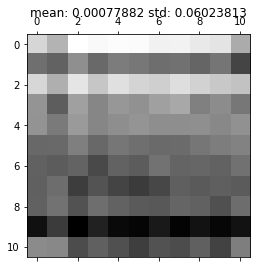

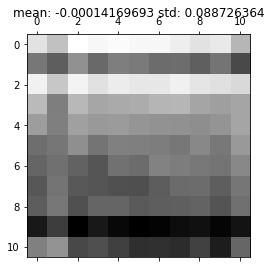

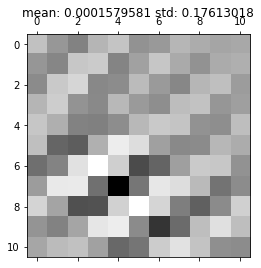

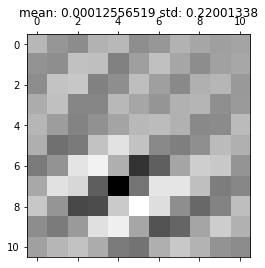

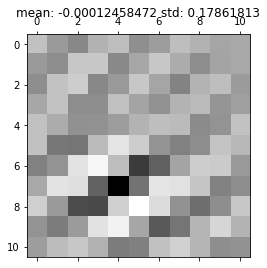

In [64]:
means = []
stds = []

for ii in range(np.shape(model.features[0].weight.data)[0]):
    for jj in range(3):
        plt.matshow(first_layer_filters[ii,jj,:,:])
 
        plt.title('mean: '+str(np.mean(np.array(first_layer_filters[ii,jj,:,:]))) + ' std: '+str(np.std(np.array(first_layer_filters[ii,jj,:,:]))))
        means.append(np.mean(np.array(first_layer_filters[ii,jj,:,:])))
        stds.append(np.std(np.array(first_layer_filters[ii,jj,:,:])))
    plt.set_cmap('Greys')
    plt.show()

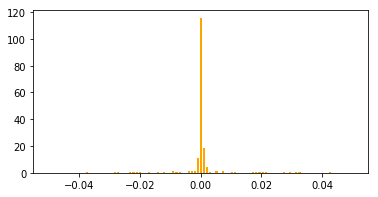

In [77]:
plotHistogram(means, -.05,.05, 100)

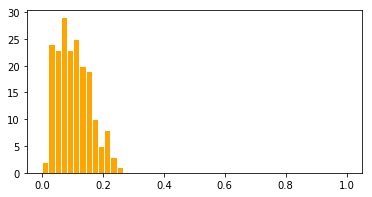

In [72]:
plotHistogram(stds, 0,1, 50)

-7.9316276e-05 0.10929794


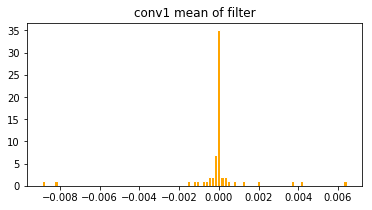

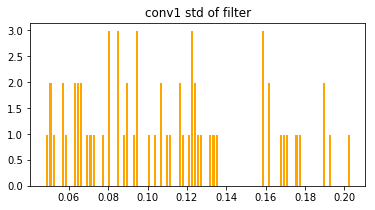

-0.0031559605 0.04582563


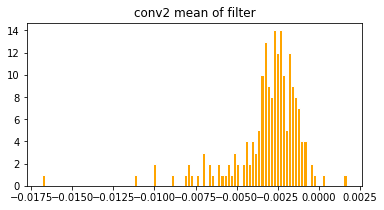

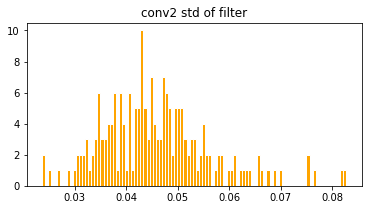

-0.002944166 0.034753907


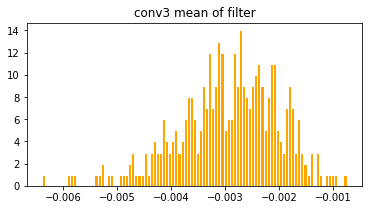

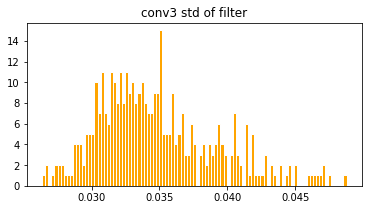

-0.0030805194 0.027511433


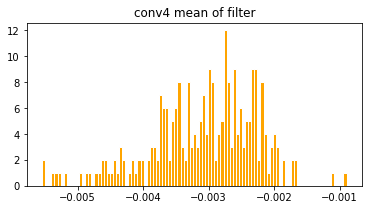

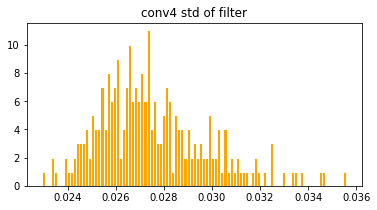

-0.0041059004 0.026325436


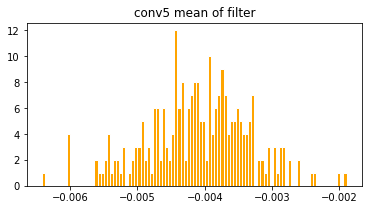

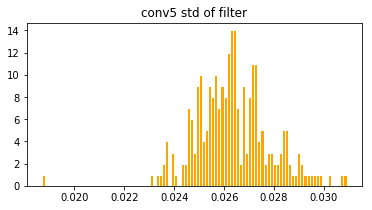

In [95]:
all_means = []
all_stds = []
jj = 1
for layer in range(12):
    means = []
    stds = []
    if 'Conv' in str(model.features[layer]):
        
        for ii in range(np.shape(model.features[layer].weight.data)[0]):
                means.append(np.mean(np.array(model.features[layer].weight.data[ii,:,:,:])))
                stds.append(np.std(np.array(model.features[layer].weight.data[ii,:,:,:])))
        all_means.append(means)
        all_stds.append(stds)
        print np.mean(means), np.mean(stds)
        plotHistogram(means, np.min(means),np.max(means), 100, 'conv' + str(jj) + ' mean of filter')
        plotHistogram(stds, np.min(stds),np.max(stds), 100, 'conv' + str(jj) + ' std of filter') 
        jj+=1

torch.Size([64, 3, 11, 11])


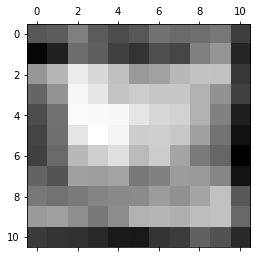

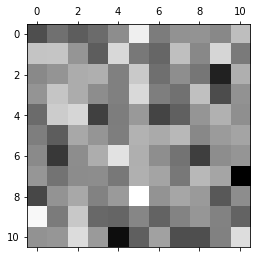

In [117]:
plt.matshow(model.features[0].weight.data[0,0,:,:])
permuted_weights = permuteWeights(model.features[0].weight.data)
plt.matshow(permuted_weights[0,0,:,:])

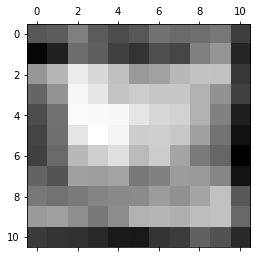

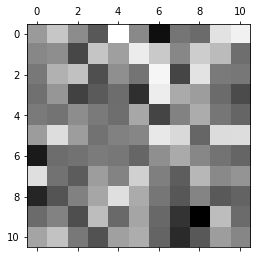

In [121]:
plt.matshow(model.features[0].weight.data[0,0,:,:])
permuted_weights = drawWeightsFromMatchedGaussian(model.features[0].weight.data)
plt.matshow(permuted_weights[0,0,:,:])

In [28]:
ex_filter = model.features[layer].weight.data[0,0,:,:]

[8.79332662e-01 4.95661616e-01 8.67386535e-02 8.03622827e-02
 4.64634709e-02 3.16650607e-02 2.29022503e-02 2.14243233e-02
 1.14086252e-02 4.30369703e-03 1.00252248e-04]
[8.7933266e-01 4.9566162e-01 8.6738653e-02 8.0362283e-02 4.6463471e-02
 3.1665061e-02 2.2902250e-02 2.1424323e-02 1.1408625e-02 4.3036970e-03
 1.0025225e-04]


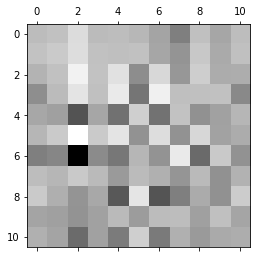

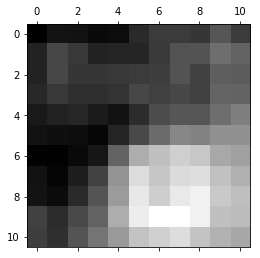

In [31]:
new_weights = randomWeightsMatchedDimensionality(ex_filter)
plt.matshow(new_weights)
u,s,t = np.linalg.svd(new_weights)
print s

plt.matshow(ex_filter)
u,s,t = np.linalg.svd(ex_filter)
print s
plt.set_cmap('Greys')

# Get random weights

In [21]:
random_permutation_weights = {}

for layer in conv_layers: 
    shape_of_weights = np.shape(model.features[layer].weight.data)
    num_filters = shape_of_weights[0]
    new_filter = np.zeros(shape_of_weights)
    
    for filt in range(num_filters):
        new_filter[filt,:,:,:] = permuteWeights(model.features[layer].weight.data[filt,:,:,:])
    
    random_permutation_weights[layer] = new_filter

torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 11, 11])
torch.Size([3, 1

torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192, 3, 3])
torch.Size([192,

torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])
torch.Size([256, 3, 3])


In [22]:
random_gaussian_weights = {}

for layer in conv_layers: 
    shape_of_weights = np.shape(model.features[layer].weight.data)
    num_filters = shape_of_weights[0]
    new_filter = np.zeros(shape_of_weights)
    
    for filt in range(num_filters):
        new_filter[filt,:,:,:] = drawWeightsFromMatchedGaussian(model.features[layer].weight.data[filt,:,:,:])
    
    random_gaussian_weights[layer] = new_filter

In [42]:
random_matched_dimensionality_weights = {}

for layer in conv_layers: 
    shape_of_weights = np.shape(model.features[layer].weight.data)
    num_filters = shape_of_weights[0]
    new_filter = np.zeros(shape_of_weights)
    
    for filt in range(num_filters):
        curr_features = model.features[layer].weight.data[filt,:,:,:]
        features_reshape = np.reshape(curr_features, (np.shape(curr_features)[0], np.product(np.shape(curr_features)[1:])))
        new_filt_need_to_reshape = randomWeightsMatchedDimensionality(features_reshape)
        new_filter[filt,:,:,:] = np.reshape(new_filt_need_to_reshape, np.shape(curr_features))
    
    random_matched_dimensionality_weights[layer] = new_filter

3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
3
121
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
25
64
2

## Replace old weights, get activations, and write shit

In [84]:
for layer_id in conv_layers:
    model = setWeights(model,random_matched_dimensionality_weights[layer_id] , layer_id)

In [10]:
path_to_images = '/home/axsys/es3773/issaLab/data/imageData/ventral_neural_data_images.npy'
images = np.load(path_to_images)
image = np.stack((images,images,images), axis=3)


In [57]:
alexnet_dimension_dict = {
'0':(5760, 64, 55, 55),
'1':(5760, 64, 27, 27),
'2':(5760, 192, 27, 27),
'3':(5760, 192, 27, 27),
'4':(5760, 192, 13, 13),
'5':(5760, 384, 13, 13),
'6':(5760, 384, 13, 13),
'7':(5760, 256, 13, 13),
'8':(5760, 256, 13, 13),
'9':(5760, 256, 13, 13),
'10':(5760, 256, 13, 13),
'11':(5760, 256, 6, 6),
'12':(5760, 256, 6, 6)
}

In [93]:
# pre-allocate hdf5 
num_files = 5760
output_path = '/home/axsys/es3773/issaLab/data/alexnet_random_filter_matched_dimensionality_features.hdf5'
with h5py.File(output_path, 'x') as f_out:
    is_valid = f_out.create_dataset("is_valid",(num_files,), dtype='int32')
    #Create datasets 
    dim_dict =  dimension_dict
    for key in dim_dict:
        print (num_files,)+ dim_dict[key][1:]
        f_out.create_dataset(str(key), (num_files,)+ (np.product(dim_dict[key][1:]),), dtype='float32')




(5760, 64, 55, 55)
(5760, 64, 27, 27)
(5760, 192, 27, 27)
(5760, 192, 27, 27)
(5760, 192, 13, 13)
(5760, 384, 13, 13)
(5760, 384, 13, 13)
(5760, 256, 13, 13)
(5760, 256, 13, 13)
(5760, 256, 13, 13)
(5760, 256, 13, 13)
(5760, 256, 6, 6)
(5760, 256, 6, 6)


In [ ]:
# Get images
path_to_images = '/home/axsys/es3773/issaLab/data/imageData/ventral_neural_data_images.npy'
images = np.load(path_to_images)
image = np.stack((images,images,images), axis=3)

### create class to extract activations

In [ ]:
class ModelFeatures(nn.Module):
    def __init__(self, original_model, layer_ind):
        super(ModelFeatures, self).__init__()
        self.features = nn.Sequential(*list(original_model.features.children())[:layer_ind+1])

    def forward(self, x):
        x = self.features(x)
        return x
       

### Extract activations

In [ ]:
dimension_dict = {}

# forward pass through the full dataset
with torch.no_grad():
        
        with h5py.File(output_path, 'a') as f_in:
            for jj in range(8,13):
                print jj
                feats = ModelFeatures(model, jj+1)
                for ii in range(0,5760):
                    if ii%100 ==0:
                        print ii
                    input_image = Image.fromarray(image[ii])
                    preprocess = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
                    input_tensor = preprocess(input_image)
                    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

                    outputs = np.array(feats(input_batch))
                    outputs = np.ndarray.flatten(outputs)
                    f_in[str(jj)][ii] = outputs



## If you want PCs like Tahereh uses

In [5]:
import pickle

In [6]:
def savePCsOfLayerActivations(model, data_path, num_pcs):
    shape = [193600, 193600, 46656, 139968, 139968, 32448, 64896, 64896, 43264, 43264, 43264, 43264, 9216] #because I am lazy
    with h5py.File(data_path, 'r') as f_in:

        for ii in range(13):
            print ii
            outputs = f_in[str(ii)]
            outputs = np.reshape(np.squeeze(outputs), (5760, shape[ii]))
            pca = PCA(n_components=num_pcs)
            pca.fit(outputs)
            pc_activations = pca.transform(outputs)

            pickle_out = open('/home/axsys/es3773/issaLab/data/alexnetData/' + model+"_"+str(ii)+"_"+str(num_pcs)+"_rand_filt.pickle","wb")
            pickle.dump(pc_activations, pickle_out)
            pickle_out.close()

In [ ]:
model = 'alexnet_random_matched_dimensionality'
data_path = '/home/axsys/es3773/issaLab/data/alexnet_random_filter_matched_dimensionality_features.hdf5'
num_pcs = 300
savePCsOfLayerActivations(model, data_path, num_pcs)